In [54]:
from edist.multiprocess import pairwise_distances_symmetric
from edist.uted import uted
from importlib import reload
from sklearn.cluster import OPTICS, cluster_optics_dbscan, DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
import chess
import json
import main
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import pandas as pd
import pickle
import random
import zss
reload(main)
from main import ChessTreeNode, expand_tree

In [ ]:
# Download and unzip stockfish
if not os.path.exists("stockfish"):
    !wget https://github.com/official-stockfish/Stockfish/releases/latest/download/stockfish-ubuntu-x86-64-avx2.tar
    !tar -xf stockfish-ubuntu-x86-64-avx2.tar

In [2]:
def convert_to_adj_node_lists(t):
    # First we label each node with an integer
    counter = itertools.count()
    idxs = {}
    stack = [t]
    all_nodes = []
    while stack:
        n = stack.pop()
        all_nodes.append(n)
        idxs[id(n)] = next(counter)
        for c in reversed(n.children):
            stack.append(c)
            
    nodes = [None for _ in idxs]
    adj = [None for _ in idxs]

    for n in all_nodes:
        nodes[idxs[id(n)]] = n.move_attributes
        adj[idxs[id(n)]] = [idxs[id(c)] for c in n.children]

    return nodes, adj

In [3]:
# Read `all_trees`, parse to ChessTreeNode, and load to memory.
trees = {}
with open("../data/trees/condor/all", "r") as f:
    for idx, line in enumerate(tqdm(f.readlines())):
        try:
            puzzle_id, tree = json.loads(line)
        except Exception: # lol
            continue
        if len(tree) == 0:
            continue

        t = ChessTreeNode(*tree[0])
        trees[puzzle_id] = (t, convert_to_adj_node_lists(t))
    with open("tree_dict.pkl", "wb") as f:
        pickle.dump(trees, f)

KeyboardInterrupt: 

In [4]:
def compare(t1, t2):
    #return zss.simple_distance(t1, t2, ChessTreeNode.get_children, ChessTreeNode.get_label, ChessTreeNode.compare)
    _, (x_nodes, x_adj) = t1
    _, (y_nodes, y_adj) = t2
    return uted(x_nodes, x_adj, y_nodes, y_adj, ChessTreeNode.compare)

def treeify_fen(fen):
    flipped = False
    board = chess.Board(fen)
    if board.turn == chess.BLACK:
        flipped = True
        board.apply_mirror()

    stockfish = chess.engine.SimpleEngine.popen_uci("./stockfish/stockfish-ubuntu-x86-64-avx2", timeout=None)
    try:
        return ChessTreeNode(*expand_tree(board.fen(), chess.Move.null(), stockfish)[0]), flipped
    finally:
        stockfish.quit()
        
df = pd.read_csv("../data/lichess/lichess_db_puzzle.csv")
def lookup_id(puzzle_id):
    matched = df.loc[df["PuzzleId"] == puzzle_id]
    return f"{puzzle_id} {matched['GameUrl'].item()} {matched['Themes'].item()}"
    

In [5]:
with open("tree_dict.pkl", "rb") as f:
    trees = pickle.load(f)

In [6]:
custom_fens = {
    "Rook Backrank M1": "6k1/5ppp/8/8/8/8/r4PPP/1R4K1 w - - 0 1",
    "N forks RK": "8/1N6/1K6/4k1p1/2P1Pp1p/4n2P/3R2P1/8 b - - 0 49",
    "Greek gift": "r1bq1rk1/pp2nppp/1bn1p3/1N1pP3/1P6/P2B1N2/2P2PPP/R1BQK2R w KQ - 3 11",
    "Rook sacrifice, Queen+Bishop M3": "4r1k1/1b3pp1/4p3/p2r4/7R/2B1Q1PP/P1P1RP1K/1q6 w - - 0 1",
}
custom_flipped = {}
for my_id, my_fen in custom_fens.items():
    t, flip = treeify_fen(my_fen)
    trees[my_id] = (t, convert_to_adj_node_lists(t))
    custom_flipped[my_id] = flip
    print("="*50)
    print(my_id)
    print(my_fen)
    print(t.flip_san(flip))
    print("="*50)

Rook Backrank M1
6k1/5ppp/8/8/8/8/r4PPP/1R4K1 w - - 0 1
Rb8# 140030717416112 1/0/0/0

N forks RK
8/1N6/1K6/4k1p1/2P1Pp1p/4n2P/3R2P1/8 b - - 0 49
Nxc4+ 140029492538320 2/1/0/0
  Kc3 140029452024912 0/1/0/0
    Nxd7 140029507733216 1/0/0/0
  Kc2 140029452015744 0/1/0/0
    Nxd7 140029491829152 1/0/0/0
  Kb4 140029452025296 1/0/0/0
    Nxd7 140029491832752 1/0/0/0
  Kc4 140029507733312 1/0/0/1
    Nxd7 140029491834288 1/0/0/0

Greek gift
r1bq1rk1/pp2nppp/1bn1p3/1N1pP3/1P6/P2B1N2/2P2PPP/R1BQK2R w KQ - 3 11
Bxh7+ 140029254844544 1/1/1/0
  Kxh7 140029254845840 0/1/0/0
    Ng5+ 140029395023968 3/0/0/1
  Kh8 140029395012928 1/1/0/1
    Ng5 140029257836032 2/1/0/1

Rook sacrifice, Queen+Bishop M3
4r1k1/1b3pp1/4p3/p2r4/7R/2B1Q1PP/P1P1RP1K/1q6 w - - 0 1
Rh8+ 140029418659456 1/1/1/0
  Kxh8 140029498165008 0/1/0/1
    Qh6+ 140012032077088 3/1/1/0
      Kg8 140029352152912 0/2/0/1
        Qxg7# 140029445256928 2/2/1/1



In [ ]:
# Find the closest puzzles for these fens
for my_id, my_fen in custom_fens.items():
    print("="*50)
    print(my_id)
    print(my_fen)
    print("="*50)
    my_tree = trees[my_id]
    distances = []
    for pid, t in tqdm(list(trees.items())[:1000], leave=False):
        if pid in custom_fens:
            continue
        distances.append((compare(t, my_tree), pid, t))
    distances.sort()

    for dist, pid, t in distances[:100]:
        print(f"(dist: {dist}) {lookup_id(pid)}")
        #print(t)
        print("-"*50)


In [7]:
np.random.seed(0)
ids = np.random.choice([k for k, _ in trees.items() if k not in custom_fens], 20000)
ids = np.concatenate((ids, list(custom_fens.keys())))
trees_short = [trees[k] for k in ids]

In [8]:
D = pairwise_distances_symmetric(trees_short, compare)


In [61]:
#optics = DBSCAN(metric="precomputed", eps=250, min_samples=20)
optics = HDBSCAN(metric="precomputed", min_cluster_size=7, cluster_selection_epsilon=100)
clust = optics.fit(D)
print(len(set(clust.labels_)))
print(set(clust.labels_))

KeyboardInterrupt: 

In [60]:
def analyse_clustering_info(cl):
    # Total num of clusters
    print(sum(1 for l in set(cl.labels_) if l != -1), end=" ")
    # Clusters preset puzzles
    for k in custom_fens.keys():
        print(cl.labels_[np.where(ids==k)[0]].item() != -1, end=" ")
    # % of -1
    print(round((cl.labels_ == - 1).sum() / len(ids), 4), end=" ")

    ln = [(cl.labels_ == p).sum() for p in set(cl.labels_) if p != -1]
    # Average cluster size
    print(round(np.array(ln).mean(), 2), end=" ")
    # Get percentiles of cluster sizes
    for perc in [0, 25, 50, 75, 100]:
        print(int(np.percentile(ln, perc)), end=" ")
    print()

for linkage in ["average", "complete", "single"]:
    for dist in [100, 250, 500]:
        print(f"AgglomerativeClustering {linkage} {dist}", end=" ")
        analyse_clustering_info(AgglomerativeClustering(metric="precomputed", n_clusters=None, linkage=linkage, distance_threshold=dist).fit(D))

for eps in [50, 100, 250, 500]:
    for min_samples in [3, 5, 7]:
        print(f"DBSCAN {eps} {min_samples}", end=" ")
        analyse_clustering_info(DBSCAN(metric="precomputed", eps=eps, min_samples=min_samples).fit(D))
 
for eps in [0, 25, 50, 100]:
    for size in [3, 5, 7]:
        print(f"HDBSCAN {eps} {size}", end=" ")
        analyse_clustering_info(HDBSCAN(metric="precomputed", cluster_selection_epsilon=eps, min_cluster_size=size).fit(D))

AgglomerativeClustering average 100 16973 True True True True 0.0 1.18 1 1 1 1 177 
AgglomerativeClustering average 250 13725 True True True True 0.0 1.46 1 1 1 1 1000 
AgglomerativeClustering average 500 8468 True True True True 0.0 2.36 1 1 1 1 1863 
AgglomerativeClustering complete 100 17224 True True True True 0.0 1.16 1 1 1 1 85 
AgglomerativeClustering complete 250 13983 True True True True 0.0 1.43 1 1 1 1 611 
AgglomerativeClustering complete 500 9063 True True True True 0.0 2.21 1 1 1 1 1000 
AgglomerativeClustering single 100 16732 True True True True 0.0 1.2 1 1 1 1 611 
AgglomerativeClustering single 250 13389 True True True True 0.0 1.49 1 1 1 1 2652 
AgglomerativeClustering single 500 7196 True True True True 0.0 2.78 1 1 1 1 10057 
DBSCAN 50 3 51 False False False False 0.9252 29.35 3 8 13 27 375 
DBSCAN 50 5 46 False False False False 0.9261 32.15 5 9 15 29 375 
DBSCAN 50 7 44 False False False False 0.9267 33.32 7 10 15 29 375 
DBSCAN 100 3 52 True False False True 0.8

KeyboardInterrupt: 

In [ ]:
# OPTICS reachability
space = np.arange(len(D))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

_, ax = plt.subplots(figsize=(18, 6))
for i in range(len(set(clust.labels_)) - 1):
    ax.plot(space[i == labels], reachability[i == labels], ".", alpha=0.3)
    
ax.plot(space[-1 == labels], reachability[-1 == labels], "k.", alpha=0.3)

In [11]:
print("Cluster of puzzles from OPTICS")
print([(p, clust.labels_[np.where(ids==p)[0]]) for p, *_ in custom_fens.items()])

for p, f in custom_fens.items():
    print(p, f)
    idx = np.where(ids==p)[0]
    this_cluster = np.nonzero(clust.labels_ == clust.labels_[idx])
    for close_id in this_cluster[0]:
        print(f"{ids[close_id]}, {D[idx, close_id][0]}")


Cluster of puzzles from OPTICS
[('Rook Backrank M1', array([37])), ('N forks RK', array([525])), ('Greek gift', array([667])), ('Rook sacrifice, Queen+Bishop M3', array([634]))]
Rook Backrank M1 6k1/5ppp/8/8/8/8/r4PPP/1R4K1 w - - 0 1
0rr22, 156.0
6Xt5a, 120.0
PTvy4, 96.0
27wW2, 100.0
Bxh4o, 140.0
AAgtF, 88.0
M0pVA, 160.0
IiBhJ, 60.0
OQLzq, 116.0
4m3UX, 124.0
Rook Backrank M1, 60.0
N forks RK 8/1N6/1K6/4k1p1/2P1Pp1p/4n2P/3R2P1/8 b - - 0 49
3lDPD, 250.0
9HMCj, 250.0
Cct67, 302.5
Nv61G, 278.5
7rfME, 290.0
5HShh, 330.5
8aDEn, 263.5
4IB35, 250.0
C5cwG, 269.0
0jzax, 288.0
6X0C0, 292.5
Olf6B, 303.5
Clye9, 262.5
EjR0I, 250.0
KvnfS, 253.0
2PSfg, 279.0
TN6rp, 291.0
2fDb4, 253.0
ILmmg, 259.0
6kJqV, 358.5
QO2ER, 261.0
I2GuE, 296.0
6wXr0, 319.0
IOjf8, 258.0
N forks RK, 250.0
Greek gift r1bq1rk1/pp2nppp/1bn1p3/1N1pP3/1P6/P2B1N2/2P2PPP/R1BQK2R w KQ - 3 11
8YUVu, 53.0
GBGWB, 53.0
Oul90, 53.0
5Z9KS, 53.0
6tgLS, 61.0
Greek gift, 53.0
Rook sacrifice, Queen+Bishop M3 4r1k1/1b3pp1/4p3/p2r4/7R/2B1Q1PP/P1P1R

In [12]:
for c in set(clust.labels_):
    print(f"label {c}")
    for pid in ids[np.where(clust.labels_==c)[0]][:7]:
        if pid in custom_fens:
            continue
        print(lookup_id(pid))
    print()

label 0
7h2Dp https://lichess.org/Kak96IN9/black#63 endgame mate mateIn1 oneMove
EUNzA https://lichess.org/bAKYRfyX#34 kingsideAttack mate mateIn1 oneMove opening
7JXEv https://lichess.org/DfGHY1nX/black#33 mate mateIn1 middlegame oneMove queensideAttack
Gspjz https://lichess.org/iWkedCsY/black#27 mate mateIn1 oneMove opening
4JrKo https://lichess.org/sLKivlyq/black#37 mate mateIn1 middlegame oneMove
J3fuJ https://lichess.org/6cCBUtdT#50 mate mateIn1 middlegame oneMove
O3v8B https://lichess.org/mfG74L9o#66 endgame mate mateIn1 oneMove

label 1
4ksKn https://lichess.org/kEacIMWr/black#109 endgame master mate mateIn1 oneMove
AAcEn https://lichess.org/LLNp0ho7#58 endgame master mate mateIn1 oneMove
BGgvc https://lichess.org/g1IqVmPS/black#87 endgame mate mateIn1 oneMove rookEndgame
5K5no https://lichess.org/tchh4y36#96 endgame mate mateIn1 oneMove rookEndgame
7zZnW https://lichess.org/gJvIqxAK/black#111 advancedPawn bishopEndgame endgame mate mateIn1 oneMove
BBfy6 https://lichess.org/t0GU

KeyboardInterrupt: 

[('Rook Backrank M1', array([3])), ('N forks RK', array([282])), ('Greek gift', array([325])), ('Rook sacrifice, Queen+Bishop M3', array([328]))]


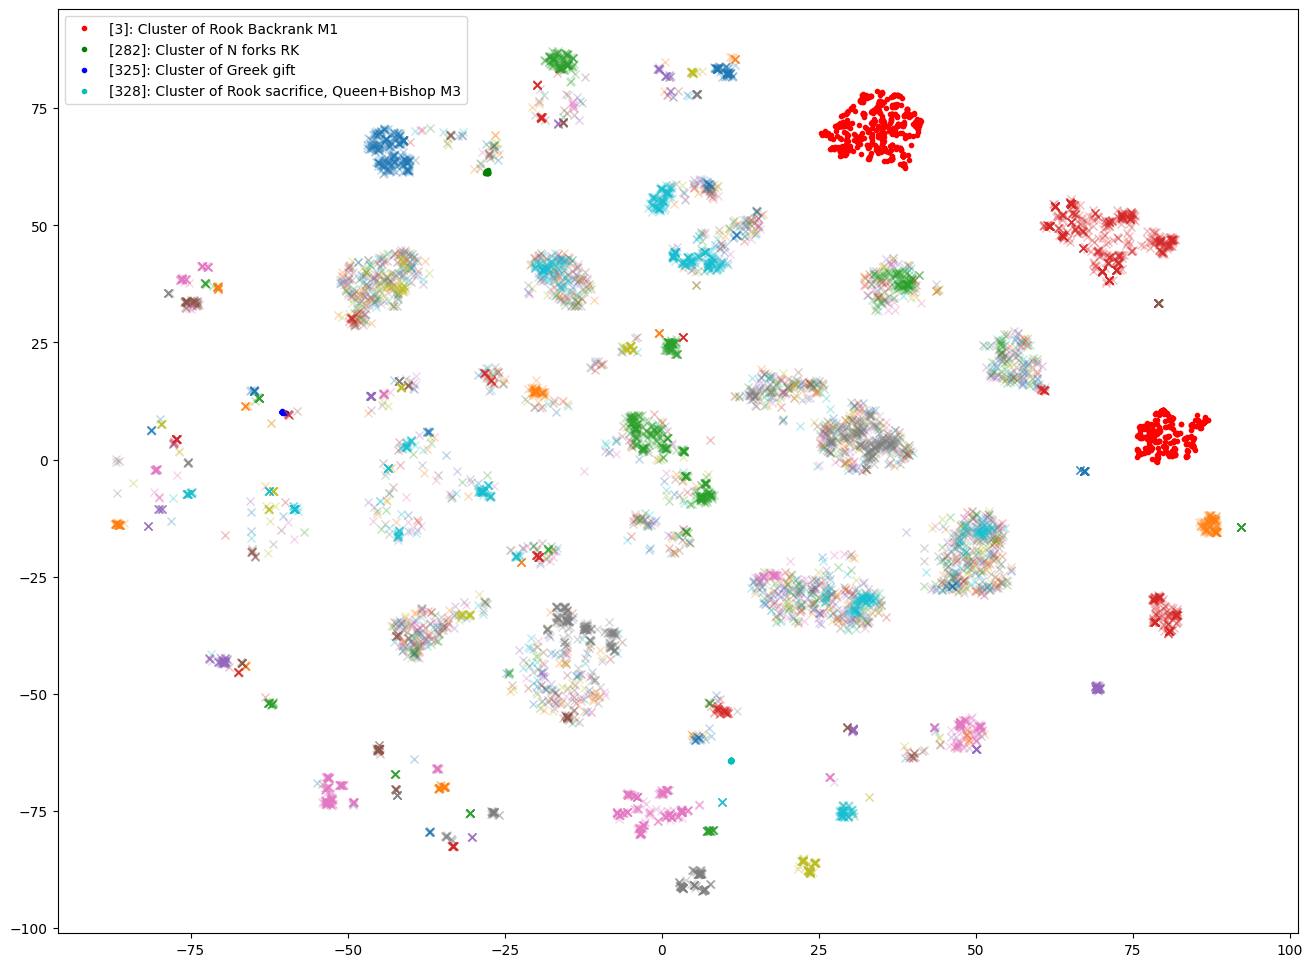

In [28]:
#tsne = TSNE(metric="precomputed", init="random", random_state=0, perplexity=50)
#y = tsne.fit_transform(D)

colours = ["r.", "g.", "b.", "c."]
labels = [(p, clust.labels_[np.where(ids==p)[0]]) for p, *_ in custom_fens.items()]
print(labels)

_, ax = plt.subplots(figsize=(16, 12))

# Plot -1 labels with faint crosses
yc = y[clust.labels_ == -1]
#ax.plot(yc[:, 0], yc[:, 1], "k.", alpha=0.1)

# Plot special colours, except -1
for (p, c), col in zip(labels, colours):
    if c == -1:
        continue
    yc = y[clust.labels_ == c]
    ax.plot(yc[:, 0], yc[:, 1], col, label=f"{c}: Cluster of {p}" )

# Plot the rest
for c in set(clust.labels_):
    if c in list(zip(*labels))[1] or c == -1:
        continue
    yc = y[clust.labels_ == c]
    ax.plot(yc[:, 0], yc[:, 1], "x", alpha=0.3)

ax.legend()
